In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, MSELoss
from torch.optim import Adam

In [ ]:
NUM_ARMS = 10
NUM_STATES = 10
BATCH_SIZE = 1
DIM_INPUT = NUM_ARMS
DIM_HIDDEN = 100
DIM_OUTPUT = NUM_ARMS
NUM_ITERS = 5_000

In [ ]:
class ContextBandit():
    def __init__(self, num_arms, num_states):
        self.num_states = num_states
        self.num_arms = num_arms
        self.prob_arms = np.random.rand(num_arms, num_arms)
        self.update_state()
        
    def update_state(self):
        self.state = np.random.choice(self.num_states)
        
    def get_state(self):
        return self.state
        
    def get_reward(self, arm_choice):
        prob = self.prob_arms[self.state, arm_choice]
        max_reward = 10
        reward = 0
        for i in range(max_reward):
            if random.random() < prob:
                reward += 1 
        return reward
        
    def choose_arm(self, arm_choice):
        reward = self.get_reward(arm_choice)
        self.update_state()      
        return reward
   
def softmax(x, temp = 2.0):
    return (np.exp(x / temp) / np.sum(np.exp(x / temp)))

def one_hot(x, num_arms = NUM_ARMS):
    vector = np.zeros(num_arms)
    vector[x] = 1
    return vector

In [ ]:
model = Sequential(
    Linear(DIM_INPUT, DIM_HIDDEN),
    ReLU(),
    Linear(DIM_HIDDEN, DIM_OUTPUT),
    ReLU(),
)

criterion = MSELoss(size_average = False)
optimizer = Adam(model.parameters(), lr = 1e-2)

In [226]:
env = ContextBandit(NUM_ARMS, NUM_STATES)

state = Tensor(one_hot(env.get_state()))

rewards = []

for i in range(NUM_ITERS):
    # Take highest reward choice
    reward_pred = model(state)   
    reward_distn = softmax(reward_pred.data.numpy())
    reward_distn /= reward_distn.sum()   
    choice = np.random.choice(NUM_ARMS, p = reward_distn)
    # Calculate loss
    reward_true = env.choose_arm(choice)
    reward_updated = reward_pred.data.numpy().copy()
    reward_updated[choice] = reward_true
    reward = Tensor(reward_updated)
    loss = criterion(reward_pred, reward)
    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Update state
    state = Tensor(one_hot(env.get_state()))
    # Log rewards
    rewards.append(reward_true)

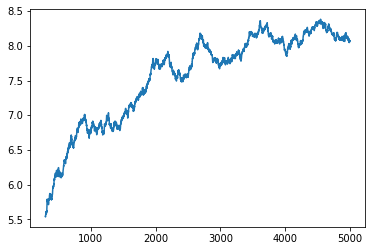

In [225]:
rewards = pd.Series(rewards)
rewards = rewards.rolling(300).mean()

plt.plot(rewards);